# Lecture 1b: Quick Introduction to New Libraries

[Data Visualization · 1-DAV-105](https://bbrejova.github.io/viz/)

Lecture by Broňa Brejová

* We will now briefly discuss several libraries which will be used in the next tutorial. 
* We will cover details of these libraries in the coming weeks, this is just a glipse of things to come.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Libraries NumPy and Pandas

* [Pandas](https://pandas.pydata.org/) is a Python library for working with tabular data. 
* [NumPy](https://numpy.org/) is a library of efficient multi-dimensional arrays used for numerical computations.

### NumPy array and arithmetical operations with arrays

* Function [`np.arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) below creates a list of numbers in interval $[1,3)$ with step 0.5 (generalization of Python `range`).
* It is stored as an object of [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) class from the Numpy library.

In [2]:
x = np.arange(1, 3, 0.5)
print('x:', x)


x: [1.  1.5 2.  2.5]


* We can do various arithmetic operations on whole NumPy arrays or apply predefined functions such as `np.exp`.
* Such operations are typically done element-by-element.

In [3]:
print('x:', x)
print('x+1:', x+1)
print('x*x:', x*x)
print('np.exp(x):', np.exp(x))

x: [1.  1.5 2.  2.5]
x+1: [2.  2.5 3.  3.5]
x*x: [1.   2.25 4.   6.25]
np.exp(x): [ 2.71828183  4.48168907  7.3890561  12.18249396]


### Creating Pandas DataFrame


* Below we create an object of Pandas DataFrame class.
* We will cover most Pandas functions used below next week, for now the details are not important.

In [4]:
def convert_table(x, function_dict):
    """ x is a list (or Numpy array) of values of x,
    function_dict is a dictionary containing function names as keys
    and lists of function values as values. The result will be a Pandas 
    DataFrame (table) with each row containing triple x, function, value.
    Zeroes and negative values are masked as missing 
    to avoid problems with logarithmic y axis."""

    # check that all functions have the same number of values as x
    for f in function_dict:
        assert(len(function_dict[f])==len(x))

    # create a wide table with each function as one columns
    functions_wide = pd.DataFrame(function_dict, index=x)
    # reformat to long format 
    #   where each row is a triple x, function name, function value
    functions = (functions_wide.reset_index()
                 .melt(id_vars='index')
                 .rename(columns={'variable':'function', 'index':'x'}))
    # mask values <= 0 as missing values
    val = functions['value']
    functions['value'] = val.mask(val <= 0, np.nan)
    return functions

In [5]:
functions = convert_table(x, {'quadratic': x * x,'cubic': x * x * x})

Let us look at the resulting table `functions`:

* It has three columns named `'x'`, `'function'` and `'value'`.
* Each row is a triple, containing a function name and the values of $x$ and $f(x)$.
* E.g. one of the rows for the cubic function has $x=2$ and $f(x)=2^3=8$.

In [6]:
display(functions)

,x,function,value
0,1.0,quadratic,1.000
1,1.5,quadratic,2.250
2,2.0,quadratic,4.000
3,2.5,quadratic,6.250
4,1.0,cubic,1.000
5,1.5,cubic,3.375
6,2.0,cubic,8.000
7,2.5,cubic,15.625


## Displaying Pandas DataFrame using Seaborn and Plotly libraries

* [Seaborn](https://seaborn.pydata.org/tutorial.html) library is an extension of Matplotlib.
* It is very convenient for displaying tables.
* In the `sns.lineplot` we first give the table and then specify, which columns should be used as x coordinate, y coordinate and color (`hue`).
* One line will be automaticlaly drawn for each distinct value in the `hue` column and a legend will be added.

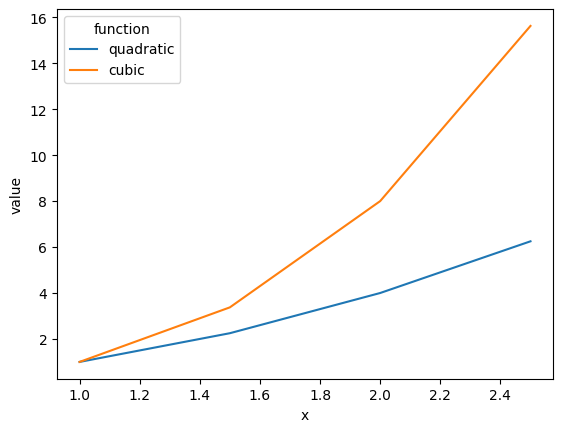

In [7]:
figure, axes = plt.subplots()
sns.lineplot(functions, x='x', y='value', hue='function', ax=axes)
pass

* Another popular library is [Plotly](https://plotly.com/python/plotly-express/).
* It provides some additional plot types and all plots are interactive. 
* For example, we can also zoom into parts of the plot by selecting a rectangle. 
* A menu with additional options appears in the top right corner of the plot.
* A line plot is created similarly as in Seaborn (option `color` is used instead of `hue`).

In [8]:

figure = px.line(functions, x="x", y="value", color='function') 
figure.show()

## Interactive plots in Plotly Dash

* [Dash](https://dash.plotly.com/) library by Plotly allows adding control elements (selectors, sliders, buttons, ...).
* It is not preinstalled in Colab, so the next line will install it.

In [ ]:
! pip install dash

* The code below creates an interactive plot in which the user can choose which functions from the list to display.
* The code has many comments so read through it carefully.


In [10]:
from dash import Dash, dcc, html, Input, Output

# create a list of all functions
all_functions = list(functions['function'].unique())

# create a new dash application app
app = Dash(__name__)

# Create layout of items in application
#   one html <div> item containing text as small headwers (H4), 
#   items for individual inputs and a graph at the bottom
# Currently we have two inputs:
#   an input field for entering title text
#   checkboxes for selecting functions 
# These elements have identifiers which will be used later in the code
app.layout = html.Div([
    html.H4("Plot title: "),
    # input field for entering title text:
    dcc.Input(
        id='graph-title',
        type='text',
        value='My plot'
    ),
    html.H4("Select functions: "),
    # checkboxes for selecting functions:
    dcc.Checklist(
        id='selected-functions',
        options=all_functions,
        value=['quadratic'],
        inline=True   # place checkboxes horizontally
    ),   
    # graph itself 
    dcc.Graph(id='graph-content')
])

# @app.callback is a function decorator applied to function update_figure below.
# It defines that this function will be called to update the graph when the user makes a change.
#    Input will be the value entered to the input field with id graph-title and 
#      the list of functions selected in dcc.Checklist object with id 'selected-functions'.
#    Output will be the graph created by the function update_figure below, which will be used
#      to update dcc.Graph object with id 'graph-content'
@app.callback(
    Output('graph-content', 'figure'),
    [Input('graph-title', 'value'), 
     Input('selected-functions', 'value')
    ]
)
def update_figure(title, selected_functions):
    """ Function for ploting functions listed in list selected_functions
    with plot title given in title"""
    
    # select a subset of functions table with just those functions in input list
    functions_subset = functions.query('function in @selected_functions')
    
    # create a plotly line plot using the smaller table in functions_subset
    figure = px.line(
        functions_subset, x="x", y="value", color="function",
        width=800, height=500
    )

    # add title to the plot
    figure.update_layout(title_text=title)    

    return figure

# run the whole application
app.run_server(mode='inline')